In [1]:
# Install packages
!pip install pandas
!pip install --upgrade pip
!pip install numpy
!pip install matplotlib
!pip install sklearn


In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from operator import itemgetter
plt.style.use('fivethirtyeight')


In [3]:
# Import 21-22 and 22-23 date
stats_21 = pd.read_csv('Players_2021_22.csv')
stats_22 = pd.read_csv('Players_2022_23.csv')

stats_21.columns
# Select columns
stats_21 = stats_21[['Player', 'Pos', 'G', 'MP', 'PTS', 'AST', 'TRB', '3P%',
                        'FG%', 'FT%', 'eFG%', 'VORP', 'TS%', 'BPM',
                        'PER', 'WS']]
stats_22 = stats_22[['Player', 'Pos', 'G', 'MP', 'PTS', 'AST', 'TRB', '3P%',
                        'FG%', 'FT%', 'eFG%', 'VORP', 'TS%', 'BPM',
                        'PER', 'WS']]

# Win Shares
ws_22 = stats_22[['Player', 'WS']]

In [4]:
# Review the dfs
stats_21.head()
stats_22.head()

,Player,Pos,G,MP,PTS,AST,TRB,3P%,FG%,FT%,eFG%,VORP,TS%,BPM,PER,WS
0,Precious Achiuwa,C,12,245,105,16,84,0.179,0.391,0.848,0.418,-0.1,0.493,-3.9,14.0,0.3
1,Steven Adams,C,14,365,91,36,153,0.000,0.612,0.290,0.612,0.1,0.564,-1.1,16.0,0.8
2,Bam Adebayo,C,14,490,267,47,128,0.000,0.531,0.855,0.531,0.2,0.590,-0.5,17.5,1.0
3,Ochai Agbaji,SG,6,67,20,1,10,0.000,0.421,0.571,0.421,-0.1,0.453,-8.4,6.6,0.1
4,Santi Aldama,PF,15,413,145,14,94,0.333,0.467,0.625,0.542,0.2,0.555,-0.1,13.7,1.0


Text(0.5, 1.0, 'Win Shares Distribution, 2021 Season')

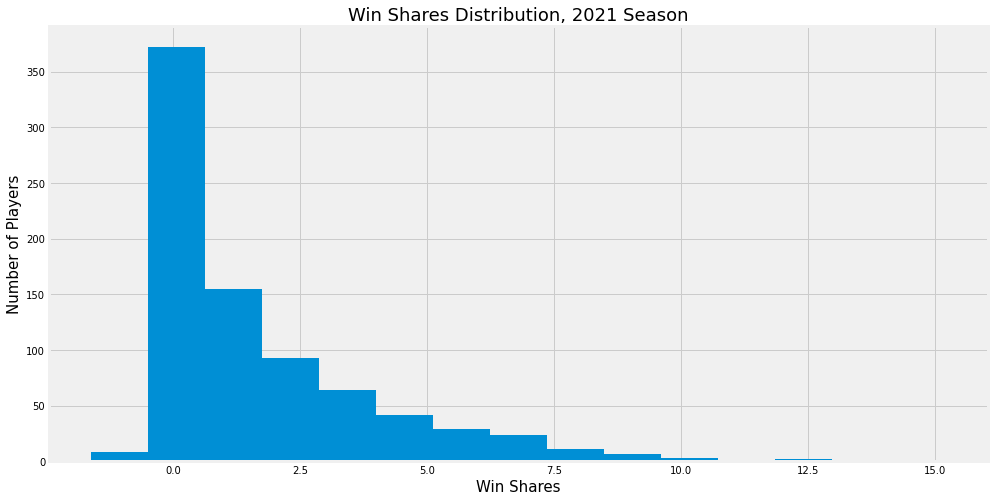

In [5]:
plt.figure(figsize=(15,8))
plt.hist(stats_21['WS'], bins=15)
plt.xlabel('Win Shares', size=15)
plt.ylabel('Number of Players', size=15)
plt.title('Win Shares Distribution, 2021 Season', size=18)

In [6]:
# Filter data to only players who played at least 30 games and averaged 20 mins a game
stats_21 = stats_21[stats_21['G'] > 30]
#stats_22 = stats_22[stats_22['G'] > 0]

stats_21 = stats_21[stats_21['MP'] > 20]
#stats_22 = stats_22[stats_22['MP']> 0]
stats_22.head()


,Player,Pos,G,MP,PTS,AST,TRB,3P%,FG%,FT%,eFG%,VORP,TS%,BPM,PER,WS
0,Precious Achiuwa,C,12,245,105,16,84,0.179,0.391,0.848,0.418,-0.1,0.493,-3.9,14.0,0.3
1,Steven Adams,C,14,365,91,36,153,0.000,0.612,0.290,0.612,0.1,0.564,-1.1,16.0,0.8
2,Bam Adebayo,C,14,490,267,47,128,0.000,0.531,0.855,0.531,0.2,0.590,-0.5,17.5,1.0
3,Ochai Agbaji,SG,6,67,20,1,10,0.000,0.421,0.571,0.421,-0.1,0.453,-8.4,6.6,0.1
4,Santi Aldama,PF,15,413,145,14,94,0.333,0.467,0.625,0.542,0.2,0.555,-0.1,13.7,1.0


Text(0.5, 1.0, 'Win Shares Distribution, 2021 Season')

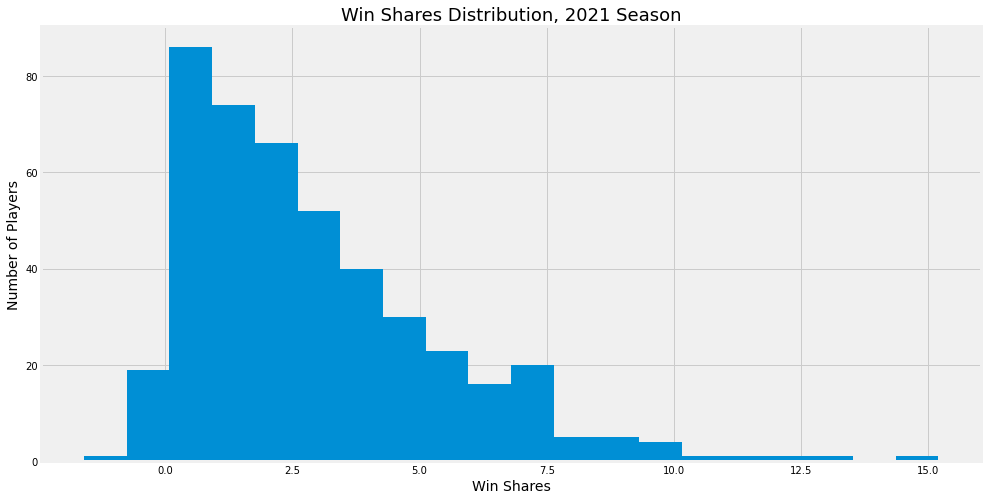

In [7]:
# Plot WS distribution
plt.figure(figsize=(15, 8))
plt.hist(stats_21['WS'], bins=20)
plt.xlabel('Win Shares', size=14)
plt.ylabel('Number of Players', size=14)
plt.title('Win Shares Distribution, 2021 Season', size=18)

In [8]:
# Correlation between Win Shares and features
corr_2021 = stats_21.corr()['WS'].reset_index()
corr_2021 = corr_2021.sort_values([('WS')], ascending=False)
corr_2021
# VORP, BPM, TRB, PER, MP, TS%, G, AST, PTS

/var/folders/h6/yxy6glj14rd2c83llgj50xnc0000gn/T/ipykernel_968/332453205.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_2021 = stats_21.corr()['WS'].reset_index()


,index,WS
13,WS,1.000000
9,VORP,0.897291
11,BPM,0.835297
4,TRB,0.773697
12,PER,0.761137
2,PTS,0.742260
1,MP,0.717359
10,TS%,0.598328
0,G,0.569688
3,AST,0.561509


Metrics for the model:
- Value Over Replacement Player (VORP)
- Player Effenciency Rating (PER)
- True Shooting % (TS%)
- Minues (MP)
- Points (PTS)
- Rebounds (TRB)

In [9]:
# Create train/test datasets
train, test = train_test_split(stats_21, test_size=.25, random_state=99)

x_train = train[['PTS', 'TS%', 'TRB', 'VORP', 'PER', 'MP']]
y_train = train[['WS']]

x_test = test[['PTS', 'TS%', 'TRB', 'VORP', 'PER', 'MP']]
y_test = test[['WS']]


In [10]:
# Create linear regression
linReg = linear_model.LinearRegression()
linReg.fit(x_train, y_train)

linReg.predict(x_test)

y_lin_pred = linReg.predict(x_test)

print('Score: %.3f' % linReg.score(x_train, y_train))
print('Mean squared error: %.3f:' % mean_squared_error(y_test, y_lin_pred))
print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_lin_pred))
print('Variance score: %.3f' % r2_score(y_test, y_lin_pred))

Score: 0.925
Mean squared error: 0.542:
Mean Absolute error: 0.531
Variance score: 0.916


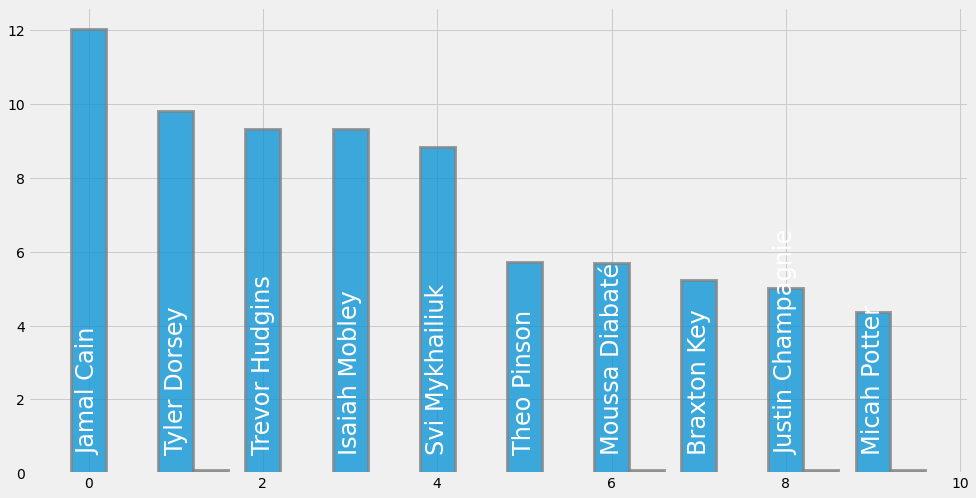

In [11]:
# Predict Win Share using linear regression
lin_new = stats_22[['PTS', 'TS%', 'TRB', 'VORP', 'PER', 'MP']]
lin_new.head()
lin_new.tail()
# print(lin_new.head(20))
# lin_new.count()
lin_pred_22 = linReg.predict(lin_new)

lin_names = stats_22.iloc[:, 0]
a = []
for i, j in zip(lin_pred_22, lin_names):
    a.append({'WS_Pred':i, 'Player': j})

lin_wins = pd.DataFrame(a)
lin_wins['WS_Pred'] = round(lin_wins['WS_Pred'].astype(float),2)

lin_wins = lin_wins.sort_values([('WS_Pred')], ascending=False).reset_index(drop=True).head(10)
lin_wins = lin_wins.merge(ws_22, on='Player', how='inner')

pos = np.arange(len(lin_wins['WS_Pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15,8))
plt.bar(pos, lin_wins['WS_Pred'], width=0.4, alpha=0.75, edgecolor='gray', linewidth=3, label='Predicted')
plt.bar(pos + .4, lin_wins['WS'], width=0.4, alpha=.75, edgecolor='gray', linewidth=3, label='Actual', color='darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s=lin_wins['Player'][i], ha='center', va='bottom', rotation='vertical', color='white', size=24)


---
# Win Shares for Chicago Bulls, 2021-22

In [12]:
players_21 = pd.read_csv('Players_2021_22.csv')

In [13]:
# Filter for Chicago Bulls Players
players_21.columns
players_21.head()
bulls_players = players_21[players_21.Tm == 'CHI']
bulls_players
# Filter for players who appeared in over 40 games
bulls_players = bulls_players[bulls_players.G >= 40]
bulls_players
bulls_players_ws = pd.DataFrame(bulls_players[['Player', 'WS']])
bulls_players_ws.columns
bulls_players_ws.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 75 to 775
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  11 non-null     object 
 1   WS      11 non-null     float64
dtypes: float64(1), object(1)
memory usage: 264.0+ bytes


In [14]:
bulls_players = bulls_players[['Player', 'G', 'MP', 'PTS', 'TS%', 'WS', 'PER', 'VORP']]
bulls_players



,Player,G,MP,PTS,TS%,WS,PER,VORP
75,Tony Bradley,55,549,163,0.600,1.3,14.9,0.0
98,Troy Brown Jr.,66,1055,283,0.525,1.4,10.1,0.1
120,Alex Caruso,41,1147,304,0.528,2.0,11.7,0.6
167,DeMar DeRozan,76,2743,2118,0.590,8.8,23.1,3.1
180,Ayo Dosunmu,77,2110,679,0.596,3.0,11.2,0.0
269,Javonte Green,65,1519,468,0.637,4.4,14.0,0.8
396,Derrick Jones Jr.,51,899,286,0.633,2.2,13.0,0.2
442,Zach LaVine,67,2328,1635,0.605,5.8,20.0,2.6
723,Matt Thomas,40,459,161,0.564,0.6,9.9,-0.1
751,Nikola Vučević,73,2418,1288,0.533,4.5,18.2,1.8


/Users/jackturek/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- G
Feature names seen at fit time, yet now missing:
- TRB

  warnings.warn(message, FutureWarning)


Text(0, 0.5, 'Win Shares')

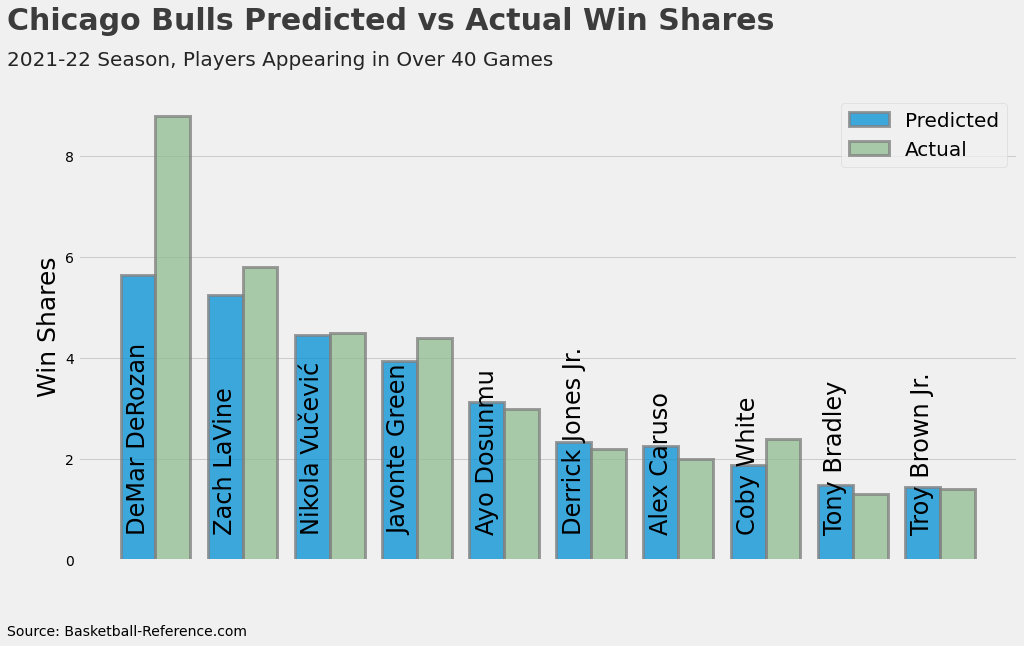

In [15]:
# # Predict Win Share using linear regression
# lin_new = stats_22[['PTS', 'TS%', 'TRB', 'VORP', 'PER', 'MP']]
# lin_new.head()
# lin_new.tail()
# # print(lin_new.head(20))
# # lin_new.count()
# lin_pred_22 = linReg.predict(lin_new)

# lin_names = stats_22.iloc[:, 0]
# a = []
# for i, j in zip(lin_pred_22, lin_names):
#     a.append({'WS_Pred':i, 'Player': j})

# lin_wins = pd.DataFrame(a)
# lin_wins['WS_Pred'] = round(lin_wins['WS_Pred'].astype(float),2)

# lin_wins = lin_wins.sort_values([('WS_Pred')], ascending=False).reset_index(drop=True).head(10)
# lin_wins = lin_wins.merge(ws_22, on='Player', how='inner')

# pos = np.arange(len(lin_wins['WS_Pred']))

# plt.style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize = (15,8))
# plt.bar(pos, lin_wins['WS_Pred'], width=0.4, alpha=0.75, edgecolor='gray', linewidth=3, label='Predicted')
# plt.bar(pos + .4, lin_wins['WS'], width=0.4, alpha=.75, edgecolor='gray', linewidth=3, label='Actual', color='darkseagreen')
# for i in pos:
#     plt.text(pos[i], 0.5, s=lin_wins['Player'][i], ha='center', va='bottom', rotation='vertical', color='white', size=24)


# Graph
bulls_new = bulls_players[['PTS', 'TS%', 'G', 'VORP', 'PER', 'MP']]
bulls_pred_21 = linReg.predict(bulls_new)

bulls_names = bulls_players.iloc[:, 0]
a=[]
for i, j in zip(bulls_pred_21, bulls_names):
    a.append({'WS_Pred': i, 'Player': j})

bulls_wins = pd.DataFrame(a)
bulls_wins['WS_Pred'] = round(bulls_wins['WS_Pred'].astype(float),2)

bulls_wins = bulls_wins.sort_values([('WS_Pred')], ascending=False).reset_index(drop=True).head(10)
bulls_wins = bulls_wins.merge(bulls_players_ws, on = 'Player', how='inner')

pos = np.arange(len(bulls_wins['WS_Pred']))

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (15, 8))
plt.bar(pos, bulls_wins['WS_Pred'], width=0.4, alpha=0.75, edgecolor='gray', linewidth=3, label = 'Predicted')
plt.bar(pos + 0.4, bulls_wins['WS'], width=0.4, alpha=.75, edgecolor='gray', linewidth=3, label = 'Actual', color = 'darkseagreen')
for i in pos:
    plt.text(pos[i], 0.5, s=bulls_wins['Player'][i], ha='center', va='bottom', rotation='vertical', color='black', size=24)
plt.text(x=-1.5, y=10.5, s = 'Chicago Bulls Predicted vs Actual Win Shares', fontsize=30, weight='bold', alpha = .75)
plt.text(x=-1.5, y=9.8, s='2021-22 Season, Players Appearing in Over 40 Games', fontsize=20, alpha=0.85)
plt.text(x = -1.5, y = -1.5, s = 'Source: Basketball-Reference.com')
plt.xticks([],[])
plt.legend(prop={'size': 20})
ax.set_ylabel('Win Shares', size=25)

---
# Win Shares Chicago Bulls 2022

In [16]:
players_22 = pd.read_csv('Players_2022_23.csv')


In [17]:
# Filter for Chicago Bulls Players

bulls_players_22 = players_22[players_22.Tm == 'CHI']
bulls_players_22
# Filter for players who appeared in over 7 games
bulls_players_22 = bulls_players_22[bulls_players_22.G >= 7]
bulls_players_22
bulls_players_ws_22 = bulls_players_22[['Player', 'WS']]
# bulls_players_ws.columns
# bulls_players_ws.info()
bulls_players_22[['Player', 'WS', 'PER']]


,Player,WS,PER
75,Alex Caruso,0.3,9.0
100,DeMar DeRozan,1.7,21.2
111,Ayo Dosunmu,0.6,11.7
113,Goran Dragić,0.5,15.3
114,Andre Drummond,0.4,21.8
152,Javonte Green,0.8,15.5
214,Derrick Jones Jr.,0.7,16.9
242,Zach LaVine,0.8,17.6
401,Dalen Terry,-0.1,4.6
420,Nikola Vučević,1.0,17.4


In [18]:
bulls_new_22 = bulls_players_22[['PTS', 'TS%', 'G', 'VORP', 'PER', 'MP']]
bulls_pred_22 = linReg.predict(bulls_new)

bulls_names_22 = bulls_players_22.iloc[:, 0]
a=[]
for i, j in zip(bulls_pred_22, bulls_names_22):
    a.append({'WS_Pred': i, 'Player': j})

bulls_wins_22 = pd.DataFrame(a)
bulls_wins_22['WS_Pred'] = round(bulls_wins_22['WS_Pred'].astype(float),2)

bulls_wins_22 = bulls_wins_22.sort_values([('WS_Pred')], ascending=False).reset_index(drop=True).head(10)
bulls_wins_22 = bulls_wins_22.merge(bulls_players_ws_22, on = 'Player', how='inner')

# pos = np.arange(len(bulls_wins['WS_Pred']))

# plt.style.use('fivethirtyeight')
# fig, ax = plt.subplots(figsize = (15, 8))
# plt.bar(pos, bulls_wins['WS_Pred'], width=0.4, alpha=0.75, edgecolor='gray', linewidth=3, label = 'Predicted')
# plt.bar(pos + 0.4, bulls_wins['WS'], width=0.4, alpha=.75, edgecolor='gray', linewidth=3, label = 'Actual', color = 'darkseagreen')
# for i in pos:
#     plt.text(pos[i], 0.5, s=bulls_wins['Player'][i], ha='center', va='bottom', rotation='vertical', color='black', size=24)
# plt.text(x=-1.5, y=10.5, s = 'Chicago Bulls Predicted vs Actual Win Shares', fontsize=30, weight='bold', alpha = .75)
# plt.text(x=-1.5, y=9.8, s='2021-22 Season, Players Appearing in Over 40 Games', fontsize=20, alpha=0.85)
# plt.text(x = -1.5, y = -1.5, s = 'Source: Basketball-Reference.com')
# plt.xticks([],[])
# plt.legend(prop={'size': 20})
# ax.set_ylabel('Win Shares', size=25)

/Users/jackturek/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- G
Feature names seen at fit time, yet now missing:
- TRB

  warnings.warn(message, FutureWarning)


ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat